# Multi-Armed Bandits

The goal of this problem set is to investigate the behaviour of a multi-armed bandit algorithm in a simple multi-
armed bandit problem.

## Action Set  
The set of actions is  
$$
A = \{1,2,3,4,5\}
$$

## Environment  
Each action $a \in A$ yields a reward $R_t$ drawn from a Bernoulli distribution $\mathrm{Ber}(p_a)$. In other words:

- If $A_t = a$, then  
  $$
  R_t =
  \begin{cases}
    1 & \text{with probability } p_a \\
    0 & \text{with probability } 1 - p_a
  \end{cases}
  $$
- The true means are:  
  $$
  p_1 = 0.8,\quad p_2 = 0.6,\quad p_3 = 0.5,\quad p_4 = 0.4,\quad p_5 = 0.2
  $$

## Regret  
The expected cumulative regret after $T$ rounds is:
$$
\mathrm{Regret}_T = \mathbb{E}\left[\sum_{t=1}^T \left(p_1 - p_{A_t}\right)\right]
$$

## UCB($\delta$) Algorithm

1. **Counters**  
   $$
   N_t(a) = \sum_{s=1}^t \mathbf{1}\{A_s = a\}
   $$  
   Number of times arm $a$ has been played by round $t$.

2. **Empirical Mean**  
   $$
   \hat{r}_t(a) = \frac{1}{N_t(a)} \sum_{s=1}^t \mathbf{1}\{A_s = a\} R_s
   $$

3. **Upper Confidence Bound**  
   $$
   \mathrm{UCB}_a(t, \delta) =
   \begin{cases}
     \infty & \text{if } N_t(a) = 0 \\
     \hat{r}_t(a) + \sqrt{\frac{\log(1/\delta)}{2N_t(a)}} & \text{otherwise}
   \end{cases}
   $$



### Imports

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## Setup

First we define a Bandit Arm class which we will use to sample each action's output. 

In [3]:
class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def sample(self):
        return np.random.binomial(1, self.p)

Now we can simply define the function that will execute the UCB algorithm described above

In [4]:
def simulate_bandit(arms, T, delta, best_p, seed=None):
    """
    Run UCB(δ) algorithm for T rounds on the given candidates.

    Arguments:
    - arms: list of BernoulliArm instances
    - T: number of rounds
    - delta: confidence level
    - best_p: true value of the best arm (used for regret calc)

    Returns:
    - cum_regrets: list of cumulative regret values at each step
    - counts: list of how many times each arm was pulled (each action was taken)
    - estimated_means: final reward estimates for each arm
    - final_ucbs: final UCB values for each arm
    """

    if seed is not None:
        np.random.seed(seed)
    

    n_arms = len(arms)
    
    # Initialize list with counts and reward sums for each arm
    # we store them in this way to avoid large memory and computation cost for large T
    counts   = np.zeros(n_arms, int)
    rewards  = np.zeros(n_arms, float)

    # Initialize regrets (including the first n_arms pulls)
    regrets = [best_p - arms[idx].p for idx in range(n_arms)]    

    # Initial pulls for each arm
    for i in range(n_arms):
        score = arms[i].sample()
        counts[i] += 1
        rewards[i] += score
    


    for t in range(n_arms, T):
        ucb_a = [ (rewards[idx] / counts[idx]) + np.sqrt(np.log(1/delta) / (2*counts[idx]))  for idx in range(n_arms)]

        i= np.argmax(ucb_a)
        chosen = arms[i]
        score = chosen.sample()

        # Update counts, rewards and regrets
        counts[i] += 1
        rewards[i] += score
        regrets.append(best_p - chosen.p)
        

    # Calculate cumulative regrets
    cum_regrets = np.cumsum(regrets)

    
    final_ucbs = [(rewards[idx] / counts[idx]) + np.sqrt(np.log(1/delta) / (2*counts[idx])) for idx in range(n_arms)]
    estimated_means = [rewards[idx] / counts[idx] for idx in range(n_arms)]

    return cum_regrets, counts, estimated_means, final_ucbs   

## Part 1: Plotting True Means vs. Final UCBs

In this first experiment, we simulate the UCB($\delta$) algorithm for $T = 10,\!000$ rounds, using a confidence parameter of  
$$
\delta = \frac{1}{T^2}
$$

We apply the algorithm to the Bernoulli bandit setting described earlier, where each arm $a \in \{1, 2, 3, 4, 5\}$ has a known true mean $p_a$.

At the end of the simulation (after all $T$ rounds), we will:
- Plot the **true means** $p_a$ for each arm,
- Plot the corresponding **upper confidence bounds** $\mathrm{UCB}_a(T, \delta)$ computed by the algorithm.

This will help us understand how well the algorithm estimates each arm’s reward, and whether the confidence bounds shrink toward the true means as expected.


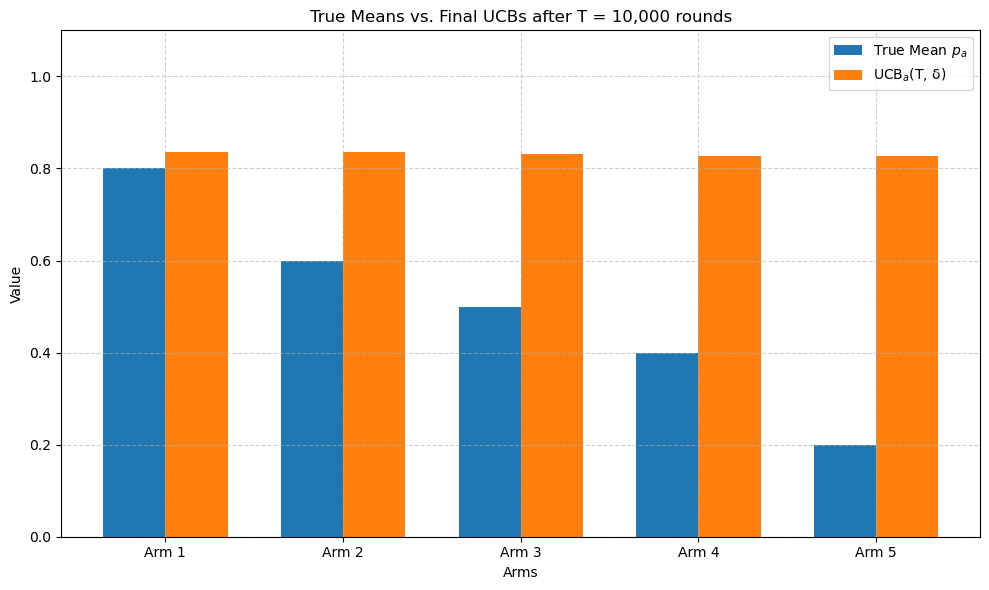

In [7]:
# Initialize arms with different probabilities
arms = [BernoulliArm(p) for p in [0.8, 0.6, 0.5, 0.4, 0.2]]

# Set parameters
T = 1e4  # Total number of rounds
delta = 1 / T**2

# Call the simulation function
cum_regrets, counts, estimated_means, final_ucbs = simulate_bandit(arms, int(T), delta, 0.8, seed=42)


# Extract true means
true_means = [arm.p for arm in arms]
arm_labels = [f"Arm {i+1}" for i in range(len(arms))]

# Create the plot
x = np.arange(len(arms))  # positions for each arm
width = 0.35  # width of each bar

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, true_means, width, label='True Mean $p_a$')
plt.bar(x + width/2, final_ucbs, width, label='UCB$_a$(T, δ)')

# Add labels and title
plt.xlabel("Arms")
plt.ylabel("Value")
plt.title("True Means vs. Final UCBs after T = 10,000 rounds")
plt.xticks(x, arm_labels)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



In [10]:
final_ucb_series = pd.Series(final_ucbs, index=arm_labels, name="Final UCB")
final_ucb_series.head(5)

Arm 1    0.835742
Arm 2    0.834964
Arm 3    0.831446
Arm 4    0.825953
Arm 5    0.827820
Name: Final UCB, dtype: float64

### Interpretation

As we know, $ UCB_a $ value represents a balance between the arm's mean reward (observed so far) and an exploration term that favours arms that have been pulled few times. Together, these form an “upper bound” on how good the arm might be. The algorithm always picks the arm with the highest bound. Even if an arm looks bad now, if it hasn’t been tried much, its upper bound might still be high — so it gets a few more chances.

By the end of a long run, the best arm has been pulled a lot so we can assume that $\hat{r}_t(a) \approx 0.8$. Looking at the results above we observe how its UCB value is just above 0.8, which indicates that its exploration bonus is small. Sub-optimal arms have lower empirical means, but they were pulled far fewer times, so their exploration bonus is comparatively large. This confidence ( $\delta$) value is just the right fit as to not give too much weight to the exploration term, yet neither prematurely commit to a wrong arm. This means that the algorithm's logic is something like *keep sampling a sub-uptimal arm only until its upper confidence bound drops below that of the best arm*. 


Digging deeper into the UCB formula, we can understand why this is optimal. 

Recall that the UCB value for arm $a$ at time $t$ is: 
$$
   \mathrm{UCB}_a(t, \delta) = \hat{r}_t(a) + \sqrt{\frac{\log(1/\delta)}{2N_t(a)}}
$$
As we know,  **Hoeffding's Inequality** ensures that:
$$ 
\mathrm{UCB}_a(t, \delta) \geq p_a
$$

In other words, the UCB is a valid upper bound on the true mean reward $p_a$ with probability at least $ 1-\delta$. 

If $\mathrm{UCB}_a(t, \delta) \lt p_a$ , we run the risk of prematurely stop exploring arm $a$, despite it actually being good. By always having $\mathrm{UCB}_a(t, \delta) \geq p_a$, we ensure that: 
- The best arm eventually stands out.
- Bad arms get discarded as their UCB's fall below the best arm's mean. 

Therefore, following this algorithm, observing all UCB values at approximately the same level means the algorithm has gathered enough information to be confident about which arm is best, and the worse arms have been pulled just enough so show that they don't matter. 

## Part 2: Investigating the Effect of the Confidence Parameter $\delta$

### Cumulative Regret Exploration

We already know that the UCB(δ) algorithm is guaranteed to achieve low regret when the confidence parameter is set to  
$
\delta = \frac{1}{T^2}.
$

In this section, we explore how changing the value of δ affects the performance of the algorithm.

To do this, we’ll run the UCB(δ) algorithm for $T = 10,\!000$ rounds using **three different values** of δ:
- $\delta = \frac{1}{T^2}$  (the theoretically recommended setting),
- $\delta = \frac{1}{\sqrt{T}}$  (less cautious — smaller exploration bonus),
- $\delta = \frac{1}{T^{1/20}}$  (very aggressive — minimal exploration bonus).

For each δ:
1. We simulate the UCB algorithm **100 times**,
2. At every time step $t$, we compute the **cumulative regret**:
   $$
   \text{Regret}_t = \sum_{s=1}^t (p_1 - p_{A_s}),
   $$
   where $p_1 = 0.8$ is the true mean of the best arm,
3. We compute the **average cumulative regret** across the 100 runs,
4. Finally, we plot all three curves together to compare the impact of different δ values.

This experiment will help us visualize how sensitive the algorithm is to the choice of δ and understand the tradeoff between **exploration** and **regret minimization**.


Running simulations for $\delta = \frac{1}{T^2}$: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]
Running simulations for $\delta = \frac{1}{\sqrt{T}}$: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]
Running simulations for $\delta = \frac{1}{T^{1/20}}$: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


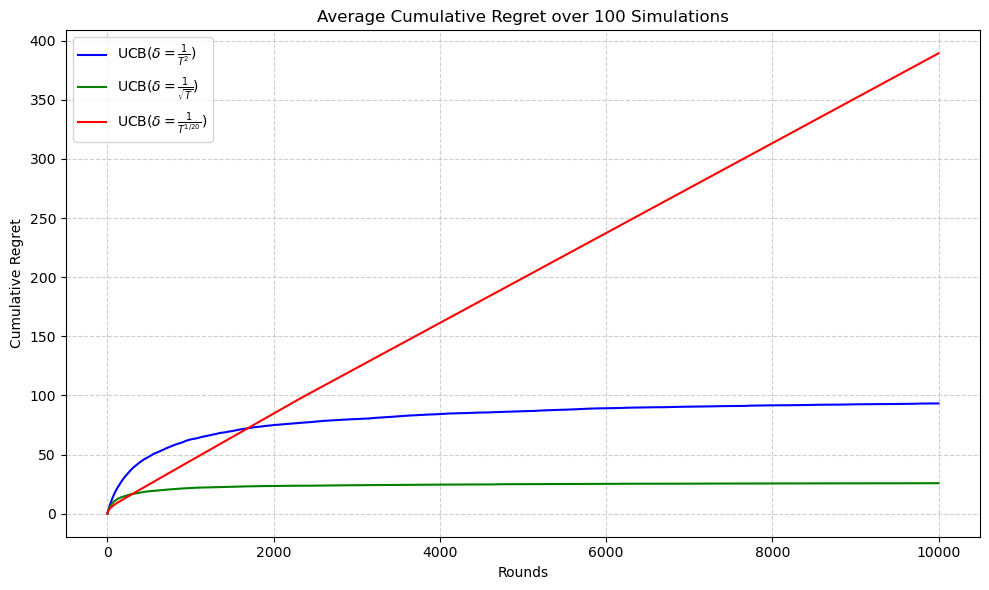

In [12]:
T = int(1e4)

# Create a dictionary of deltas that we will loop over
deltas = {
    r"$\delta = \frac{1}{T^2}$": 1 / T**2,
    r"$\delta = \frac{1}{\sqrt{T}}$": 1 / np.sqrt(T),
    r"$\delta = \frac{1}{T^{1/20}}$": 1 / T**(1/20)
}

# Initialize arms
arms = [BernoulliArm(p) for p in [0.8, 0.6, 0.5, 0.4, 0.2]]

# Dictionary to store cumulative regrets
avg_regrets = {}

for label, delta in deltas.items():
    regrets = np.zeros(T)
    for i in tqdm(range(100), desc=f"Running simulations for {label}"):
        cum_regrets, _, _, _ = simulate_bandit(arms, T, delta, 0.8, seed=i)
        regrets += np.array(cum_regrets)
    avg_regrets[label] = regrets / 100

# Plot
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']

for (label, avg_regret), color in zip(avg_regrets.items(), colors):
    plt.plot(avg_regret, label=f"UCB({label})", color=color)

plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.title("Average Cumulative Regret over 100 Simulations")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### Interpretation

From the plot above, we can easily spot two distinct trends. On one side, we have the cumulative regret curves for $\delta = \frac{1}{T^2}$ (blue) and $\delta = \frac{1}{\sqrt{T}}$ (green), which both grow slowly and eventually level off. On the other side, the red curve for $\delta = \frac{1}{T^{1/20}} \approx 0.6$ shows a totally different pattern — a steep, almost linear increase.

Looking at the blue curve first ($\delta = \frac{1}{T^2}$), we see that regret grows slowly and eventually flattens out around 95. This makes sense: with such a small $\delta$, the exploration term is large, so the algorithm is cautious and gives all arms plenty of chances before settling. The green curve ($\delta = \frac{1}{\sqrt{T}}$) shows the same overall shape, but it flattens much earlier (around 1,000 rounds) and stabilizes at a lower regret — around 25. That’s because it explores less aggressively. Mathematically:  
- for $\delta = \frac{1}{T^2}$, the bonus term grows like $\sqrt{\frac{2\log T}{N}}$  
- for $\delta = \frac{1}{\sqrt{T}}$, it’s only $\sqrt{\frac{0.5\log T}{N}}$

So halving the log factor roughly quarters the regret. 

While $\delta = \frac{1}{\sqrt{T}}$ gives lower average regret than $\delta = \frac{1}{T^2}$, it comes at a cost. The theoretical guarantees are weaker because you're more likely to make a bad decision due to less exploration — the failure probability goes from $\frac{1}{T}$ to $\frac{\sqrt{T}}{T}$. 

One thing to keep in mind is that when the blue and green curves appear to “stabilize,” they’re not totally flat — regret is still increasing, just very slowly. After around 6,000 rounds, the slope becomes so small that the curve looks flat, but tiny amounts of regret continue to accumulate. 

Regarding the red curve ($\delta = \frac{1}{T^{1/20}}$), things go differently. Since $\delta$ is so large (about 0.6), the exploration term is tiny — $\log(1/\delta) \approx 0.5$, compared to $\log(1/\delta) \approx 18.4$ for $\delta = \frac{1}{T^2}$. That means the UCB bonus barely plays a role, especially after the first few pulls. So if an arm happens to get lucky early on — even if it’s not the best one — the algorithm locks onto it and never switches. This causes regret to grow almost linearly over time.



### Final UCB values exploration

We can also generate the same final UCB values plot for the three different $\delta$ values:

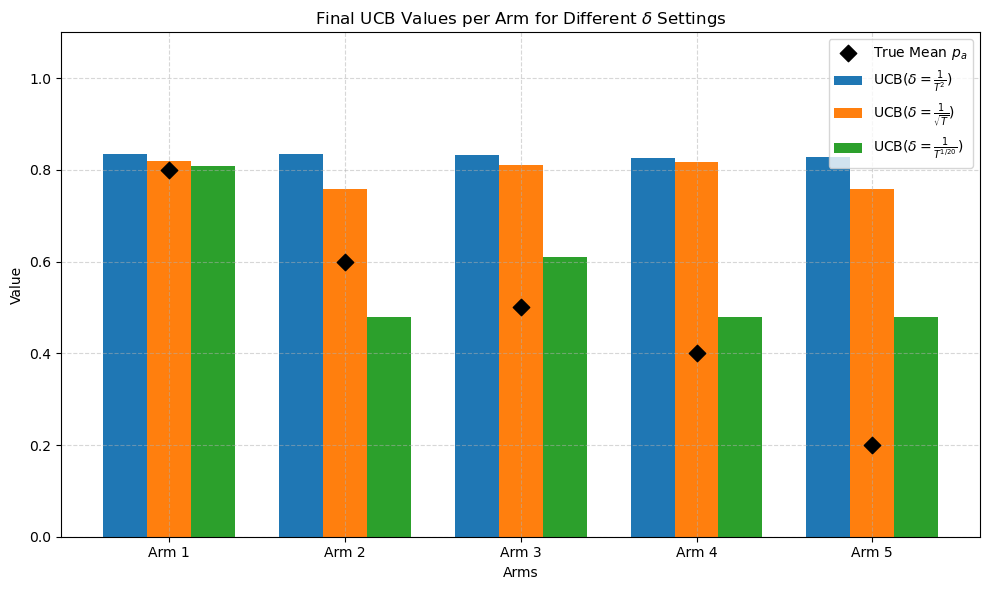

In [ ]:
# Call the simulation function
final_ucbs = {}
for label, delta in deltas.items():
    _, _, _, final_ucb = simulate_bandit(arms, T, delta, 0.8, seed=42)
    final_ucbs[label] = final_ucb


# Extract true means
true_means = [arm.p for arm in arms]
arm_labels = [f"Arm {i+1}" for i in range(len(arms))]

# Set up
n_arms = len(arms)
x = np.arange(n_arms)  
width = 0.25           

# Color and offset mapping
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green
offsets = [-width, 0, width]
labels = list(final_ucbs.keys())

# Create plot
plt.figure(figsize=(10, 6))

for i, (label, delta_label) in enumerate(zip(labels, final_ucbs.values())):
    plt.bar(x + offsets[i], delta_label, width, label=f"UCB({label})", color=colors[i])

# Plot true mean as horizontal lines per arm
plt.scatter(x, true_means, color='black', label='True Mean $p_a$', zorder=5, marker='D', s=70)

# Decorations
plt.xticks(x, arm_labels)
plt.xlabel("Arms")
plt.ylabel("Value")
plt.ylim(0, 1.1)
plt.title(r"Final UCB Values per Arm for Different $\delta$ Settings")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Interpretation

Results for  $\delta = \frac{1}{T^2}$ (blue) and $\delta = \frac{1}{\sqrt{T}}$ (orange) confirm that the UCB values stabilize as the lower reward arms eventually get values lower than our best performing arm. Once this happens, the agorithm has found its best arm and sticks to it. 

However, the more interesting results are those from $\delta = \frac{1}{T^\frac{1}{20}}$. The first thing we notice is that the UCB values for the sub-optimal arms are way lower than the others. In fact, for some it is even lower than the real mean $p_a$. Hoeffding's inequality showed us that the UCB served as an upper bound for the true mean, but only with probability $1 - \delta$. Because in this case $\delta = \frac{1}{T^\frac{1}{20}} \approx 0.6$, there is a very real chance of the true mean being higher than the UCB. 

Because they are sampled just once (and maybe get an unlucky “0”), their empirical means stay low and the mini-bonus cannot lift them, and the algorithm never re visits them. Therefore, only the initial winner gets pulled (hence the difference between its UCB value and the true mean is the tighest of all $\delta$ values). 

### Extreme $\delta$ value exploration

Lastly, let's explore how an extreme value of our Confidence parameter $\delta$. 

We now run a few simulations raising T to the power of 0. This means that $\delta = \frac{1}{T^0} = 1$, which leads to the exploration bonus being:
$$
 \sqrt{\frac{\log(1/\delta)}{2N_t(a)}} = \sqrt{\frac{\log(1)}{2N_t(a)}} = \sqrt{\frac{0}{2N_t(a)}} = 0
$$

Therefore, our UCB values turn into: $ UCB_a(t, \delta) = \hat{r}_t(a) $ which essentially becomes a purely **Greedy Algorithm**



Due to the high instability that this induces, we plot the final UCB values first for a single run, but also averaging results over 10 and 100 runs. Additionally, for the 10 sample average we plot the Std

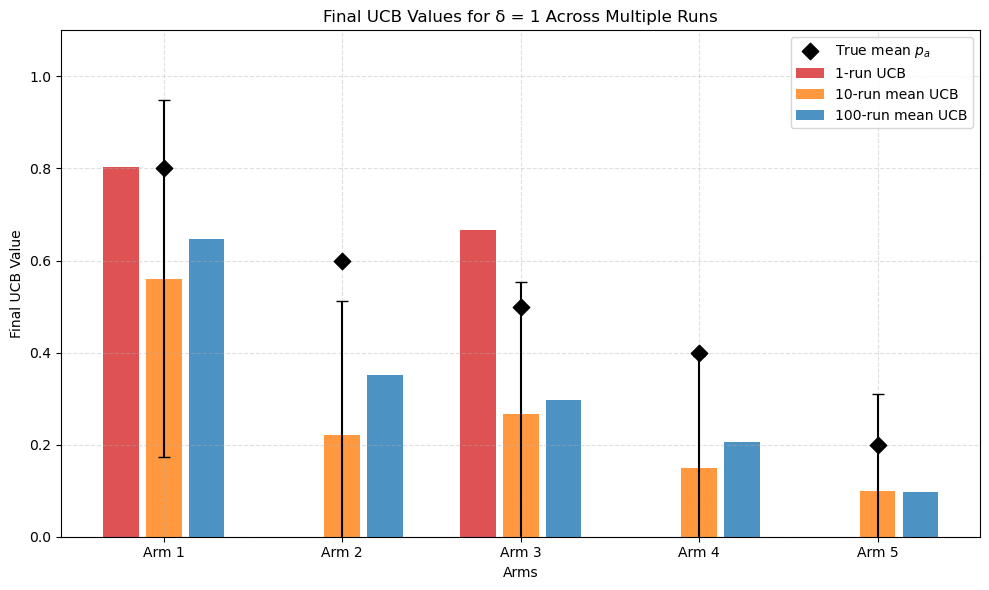

In [17]:
delta_1 = 1.0
n_arms   = len(arms)
n_runs   = [1, 10, 100]
colors   = ['#d62728', '#ff7f0e', '#1f77b4']  # red→orange→blue progression

# Run simulations and collect final UCBs
all_ucbs = {k: np.zeros((k, n_arms)) for k in n_runs}

for k in n_runs:
    for i in range(k):
        _, _, _, final_ucb = simulate_bandit(arms, T, delta_1, 0.8, seed=i)
        all_ucbs[k][i] = final_ucb

# --- plotting ---
x = np.arange(n_arms)
width = 0.2  # Slightly narrower to fit all bars neatly

plt.figure(figsize=(10, 6))

# Layer 1: 1-run final UCB (bar)
ucb1 = all_ucbs[1][0]
plt.bar(x - width*1.2, ucb1, width, color=colors[0], alpha=0.8, label='1-run UCB')

# Layer 2: mean ± SD for 10 runs (error bars on top of bars)
mean10 = all_ucbs[10].mean(axis=0)
std10  = all_ucbs[10].std(axis=0, ddof=1)
plt.bar(x, mean10, width, color=colors[1], alpha=0.8, label='10-run mean UCB')
plt.errorbar(x, mean10, yerr=std10, fmt='none', ecolor='black', capsize=4)

# Layer 3: mean for 100 runs (bar)
mean100 = all_ucbs[100].mean(axis=0)
plt.bar(x + width*1.2, mean100, width, color=colors[2], alpha=0.8, label='100-run mean UCB')

# True means (black diamonds)
true_means = [arm.p for arm in arms]
plt.scatter(x, true_means, color='black', marker='D', s=70, label='True mean $p_a$', zorder=5)

# Cosmetics
plt.xticks(x, [f'Arm {i+1}' for i in x])
plt.ylim(0, 1.1)
plt.xlabel('Arms')
plt.ylabel('Final UCB Value')
plt.title('Final UCB Values for δ = 1 Across Multiple Runs')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()